## Public Waybill Data ETL

The publicly available waybill data, along with the Railinc reference documentation, can be downloaded from the Surface Transportation Board <a href="https://prod.stb.gov/reports-data/waybill/">here</a>.

I don't think we'll be needing anything too fancy to prepare this data for analysis, so I'll only be importing pandas and numpy.

In [1]:
import pandas as pd
import numpy as np

I've downloaded the data and reference guide already. The data file has been formatted as a flat, 247-byte-per-line .txt file. Let's take a look at the raw data to get an idea of what we're working with.

In [2]:
FILE_PATH = './'

In [3]:
with open(FILE_PATH + 'PublicUseWaybillSample2019.txt', 'r') as f:
    lines = f.readlines()
    print(lines[:5])

['01101701190001PC214XPI 41   0000   374220000027000002700000075800000000000000000020990030070140401704000641                  0641100000000000000000000000000000  0000879                                              T00004000000108000000030320000000\n', '12141701190001PS342FCA 46X  0001PC 461110000010000001000000193100000000000000000019999900860120400004000101                  0641100000662217628806100507050504EF8841379                                              T00004000000040000000077240000040\n', '01121801190001RF483FBC 49   0000   374220000030000003000000165200000000000000000020990000360130401704001465                  1810100000225060708007091015060208E41507900                                              T00004000000120000000066080000000\n', '01261801190001RA806XP  38   0000   371490000043000004300000496100000000000000000019190921080140400004000961                  1344110000151112509210091117001610E41500000                                              T000040000001720000001984

At face value, this data is a nightmare; it just looks like maybe 6 columns of perhaps tab-delimited alpha-numeric serial references. However, we can find some help in the reference guide in the section "2019 Surface Transportation Board Public Use Waybill 247-Byte Record Layout" (p. 99). Here we find a table that will help us in decoding the data, shown below:

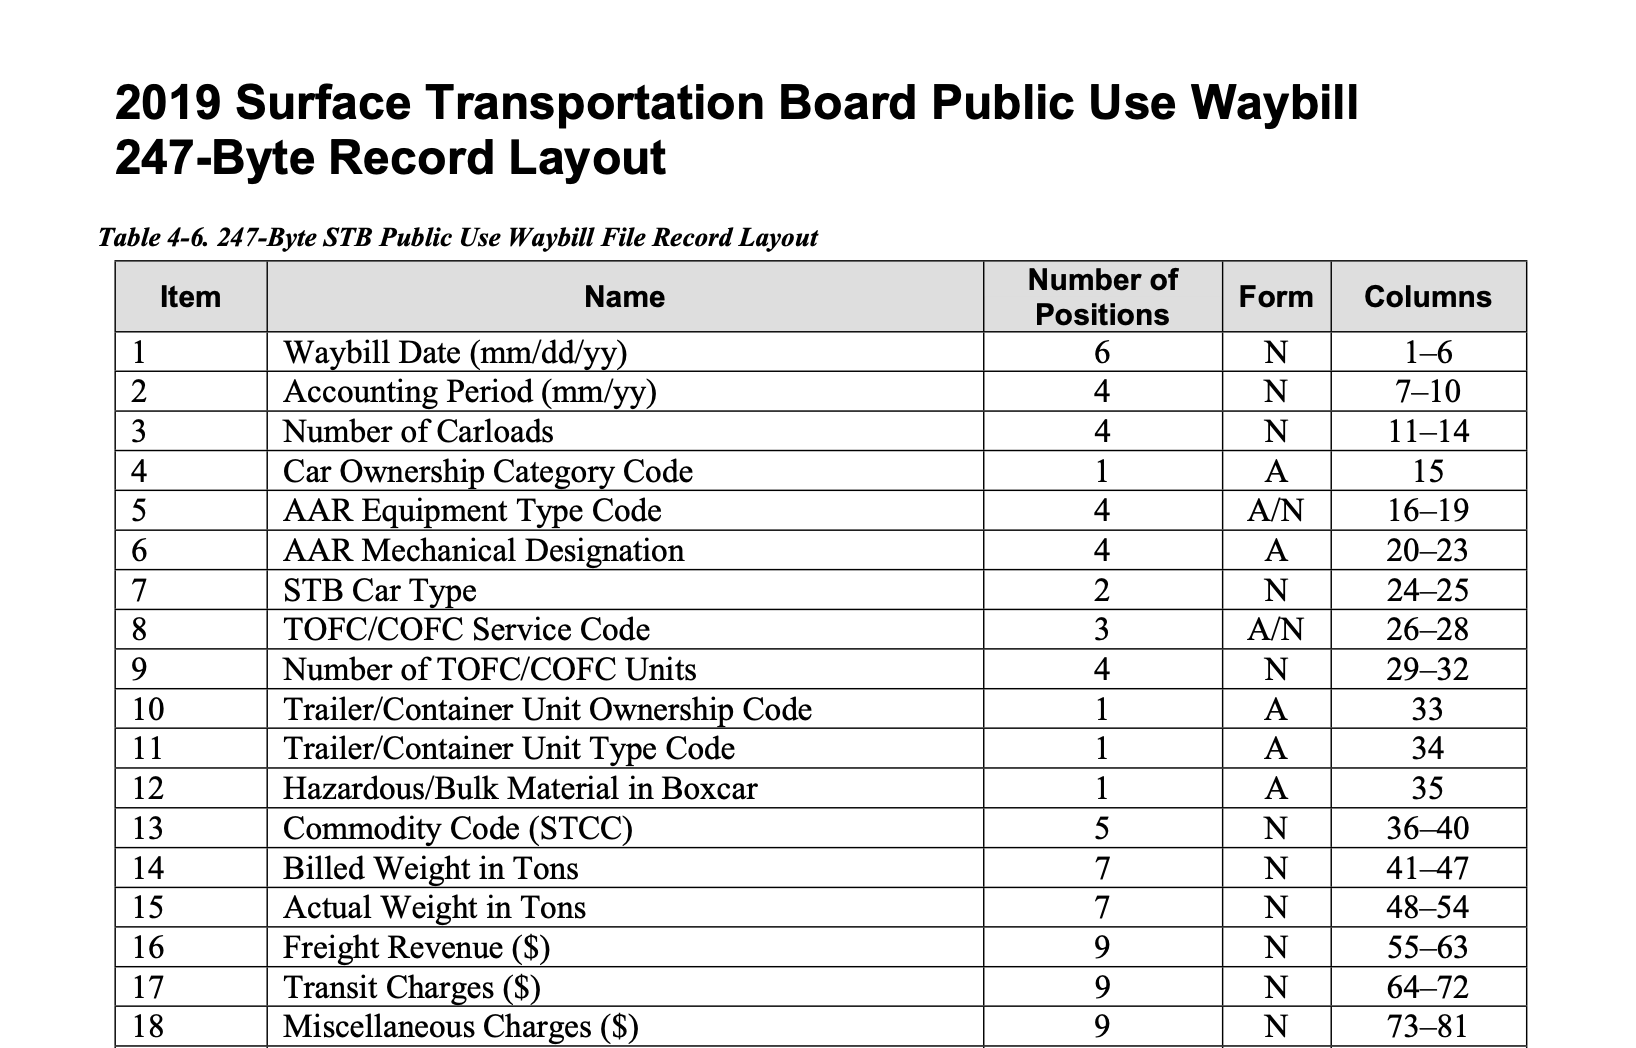

This is only the first few rows of the table, but this table provides us with the field names in the data, along with the character positions that hold the data for a particular field.

First, since this table is in a pdf document, we'll need to get it into some workable format for us to use in our code. I was able to copy and paste it into Excel, but the formatting was still a hassle. After formatting the data, I saved it to a .csv file, to be read in by pandas.

Let's take a look at the data:

In [4]:
column_lookup_path = FILE_PATH + 'column_positions_lookup.csv'

In [5]:
column_lookup_df = pd.read_csv(column_lookup_path, delimiter=',')
column_lookup_df.head()

,item,name,number_of_positions
0,1,waybill_date,6
1,2,accounting_period,4
2,3,number_of_carloads,4
3,4,car_ownership_category_code,1
4,5,aar_equipment_type_code,4


Now let's make a lookup dictionary that we can use to look up a column's name and the number of character positions that column should contain.

In [6]:
column_lookup_dict = {k: v for k,v in column_lookup_df[['name', 'number_of_positions']].to_numpy()}

We can use this dictionary, along with the following function, to parse each line of the data and create a JSON-like list of dictionaries containing the data.

In [7]:
def read_waybill_line(line, lookup_dict):
    out = {}
    start = 0
    for key in lookup_dict:
        if key == 'blank':
            continue
        end = start + int(lookup_dict[key])
        out[key] = line[start: end]
        start = end
        
    return out

In [8]:
dataset = []
for line in lines:
    dataset.append(read_waybill_line(line, column_lookup_dict))

Let's convert the data to a pandas DataFrame and preview it.

In [9]:
df = pd.DataFrame(dataset)
df.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes,routing_error_flag,expanded_carloads,expanded_tons,expanded_freight_revenue
0,011017,0119,0001,P,C214,XPI,41,,0000,,...,0000,,,00,0,0879,,,,
1,121417,0119,0001,P,S342,FCA,46,X,0001,P,...,0504,E,F,88,4,1379,,,,
2,011218,0119,0001,R,F483,FBC,49,,0000,,...,0208,E,4,15,0,7900,,,,
3,012618,0119,0001,R,A806,XP,38,,0000,,...,1610,E,4,15,0,0000,,,,
4,020218,0119,0015,P,C112,LO,41,,0000,,...,0903,E,4,66,0,5600,,,,


That looks much better!

Now that we have the data in a readable format, let's take a look at the shape, data types, and memory footprint.

In [10]:
df.shape

(676257, 61)

In [11]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676257 entries, 0 to 676256
Data columns (total 61 columns):
waybill_date                             676257 non-null object
accounting_period                        676257 non-null object
number_of_carloads                       676257 non-null object
car_ownership_category_code              676257 non-null object
aar_equipment_type_code                  676257 non-null object
aar_mechanical_designation               676257 non-null object
stb_car_type                             676257 non-null object
tofc_cofc_service_code                   676257 non-null object
number_of_tofc_cofc_units                676257 non-null object
trailer_container_unit_ownership_code    676257 non-null object
trailer_container_unit_type_code         676257 non-null object
hazardous_bulk_material_in_boxcar        676257 non-null object
commodity_code_stcc                      676257 non-null object
billed_weight_in_tons                    676257 non-null 

So this is a pretty big dataset, with over 670k rows, and it's eating up a ton of memory -- about 2.4 GB!

We have a couple of red flags here, though, that we should inspect: first, 670k rows is big, but not big enough to merit a 2.3 GB memory footprint; second, none of the columns contain any null values -- which we know should not be the case from our preview of the pandas data.

So we'll tackle the "no nulls" issue first. From inspecting the original .txt file, we can see that all the values that should be null have been filled with spaces, which eats up memory by both simply having the spaces there at all and by forcing some of the numerical columns to be encoded as text. However, with some regex, we can find and replace these values with np.nan.

Once that is done, we can cast the columns to their proper datatypes, and check their min and max values to make sure that we are using the proper number of bits for our integers.

The following function will complete these tasks and give us a summary at the end of the memory reduction.

In [12]:
def minimize_mem_usage(df, verbose=False):
    start_mem_usg = df.memory_usage(deep=True).sum() / 1024**2 # MB
    
    # replace space-filled values with np.nan
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    df['waybill_date'] = pd.to_datetime(df['waybill_date'], format='%m%d%y')
    df['accounting_period'] = pd.to_datetime(df['accounting_period'], format='%m%y')
    
    # cast numerical columns to int
    for col in df.columns:
        if col in ['waybill_date', 'accounting_period']:
            continue
        try:
            df[col] = df[col].astype(int)
        except ValueError:
            continue
    
    # drop na's
    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)
    
    NAlist = []
    for col in df.columns:
        if df[col].dtype not in ['object', 'datetime64[ns]']:
            
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
    
    # Print final result
    end_mem_usg = df.memory_usage().sum() / 1024**2
    mem_reduction = 100*end_mem_usg/start_mem_usg
    
    if verbose:
        print("___MEMORY REDUCTION STATS:___")
        print("Starting memory usage was {:.2f}MB".format(start_mem_usg))
        print("Current memory usage is {:.2f}MB".format(end_mem_usg))
        print("This is {:.2f}% of the initial size".format(mem_reduction))
    
    return df

In [13]:
df = minimize_mem_usage(df, verbose=True)

___MEMORY REDUCTION STATS:___
Starting memory usage was 2462.56MB
Current memory usage is 127.05MB
This is 5.16% of the initial size


We have great performance coming out of our memory optimization, with a reduction of about 95% of the original memory!

Let's have a quick look at our datatypes to make sure everything went well and makes sense.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676257 entries, 0 to 676256
Data columns (total 53 columns):
waybill_date                             676257 non-null datetime64[ns]
accounting_period                        676257 non-null datetime64[ns]
number_of_carloads                       676257 non-null uint8
car_ownership_category_code              676257 non-null object
aar_equipment_type_code                  676257 non-null object
aar_mechanical_designation               676257 non-null object
stb_car_type                             676257 non-null uint8
tofc_cofc_service_code                   410310 non-null object
number_of_tofc_cofc_units                676257 non-null uint8
trailer_container_unit_ownership_code    410367 non-null object
trailer_container_unit_type_code         410367 non-null object
hazardous_bulk_material_in_boxcar        61465 non-null object
commodity_code_stcc                      676257 non-null uint16
billed_weight_in_tons                    6762

We can see above that we now have plenty of null values (which is a good sign), and our integer data types have been optimized to the lowest bit size of unsigned integer types, giving us a very reasonable 127MB of data.

We'll have one final look at the data, and then save it to a .csv for later use in analysis.

In [15]:
df.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,tare_weight_of_car,outside_length,outside_width,outside_height,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes
0,2017-01-10,2019-01-01,1,P,C214,XPI,41,NaN,0,NaN,...,0,0,0,0,0,NaN,NaN,0,0,879
1,2017-12-14,2019-01-01,1,P,S342,FCA,46,X,1,P,...,2176,28806,1005,705,504,E,F,88,4,1379
2,2018-01-12,2019-01-01,1,R,F483,FBC,49,NaN,0,NaN,...,607,8007,910,1506,208,E,4,15,0,7900
3,2018-01-26,2019-01-01,1,R,A806,XP,38,NaN,0,NaN,...,1125,9210,911,1700,1610,E,4,15,0,0
4,2018-02-02,2019-01-01,15,P,C112,LO,41,NaN,0,NaN,...,526,4200,1008,1506,903,E,4,66,0,5600


In [16]:
df.to_csv('./prelim_waybill_data.csv', index=False)

We'll go ahead and create a csv for this dataset, even though it will not be the final dataset. That way if later on we decide to alter the future ETL steps, we can rely on this baseline dataset.

### Combining with other data sources

We have our waybill data clean now, but we will need a couple of other datasets to get a complete picture. In particular, we will need to decode the Surface Transportation Commidity Codes (STCC) and Business Economic Area (BEA) codes, so that we can know what type of freight is being moved and its origin and destination points.

The STCC code headers and BEA codes can be found in similar tables to the data position tables in the reference guide. I've copied the tables into csv's.

We'll read all the data back into Spark DataFrames, so that we can take advantage of Spark SQL to combine the data.

In [17]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()

In [18]:
waybill = spark.read.csv('./prelim_waybill_data.csv', header=True, inferSchema=True)
stcc = spark.read.csv('./stcc_data.csv', header=True, inferSchema=True)
bea = spark.read.csv('./bea_codes.csv', header=True, inferSchema=True)

waybill.createOrReplaceTempView('waybill')
stcc.createOrReplaceTempView('stcc')
bea.createOrReplaceTempView('bea')

#### read in hazardous data

In [19]:
haz_query = """
SELECT
    w.*,
    s.short_description as stcc_description,
    o.location as origin_location,
    t.location as terminal_location,
    s.is_hazardous
FROM waybill w
JOIN stcc s ON s.stcc_code = LEFT(w.commodity_code_stcc,2) /* stcc_code contains only the first 2 digits of the stcc */
JOIN bea o ON o.bea_code = w.origin_bea_area
JOIN bea t ON t.bea_code = w.termination_bea_area
WHERE 1=1
    AND s.is_hazardous = 1
"""

hazardous = spark.sql(haz_query)
hazardous.count()

34243

In [20]:
hdf = hazardous.toPandas()
hdf.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes,stcc_description,origin_location,terminal_location,is_hazardous
0,2018-04-16,2019-01-01,1,P,T105,T,50,None,0,None,...,306,E,4,77,0,0,Chemicals,"Chicago-Gary-Kenosha, IL-IN-WI","Los Angeles-Riverside-Orange County, CA-AZ",1
1,2018-08-30,2019-01-01,1,P,C214,LO,41,None,0,None,...,806,E,4,88,0,0,Chemicals,"Chicago-Gary-Kenosha, IL-IN-WI","Philadelphia-Wilmington-Atlantic City, PA-NJ-D...",1
2,2018-09-05,2019-01-01,1,P,C214,LO,41,None,0,None,...,810,E,4,88,0,0,Chemicals,"New Orleans, LA-MS","Birmingham, AL",1
3,2018-10-10,2019-01-01,1,P,S342,FCA,46,X,1,P,...,504,E,F,88,4,1300,Chemicals,"Baton Rouge, LA-MS",Alberta,1
4,2018-10-23,2019-01-01,1,P,T106,T,51,None,0,None,...,400,E,4,77,0,0,Chemicals,"Chicago-Gary-Kenosha, IL-IN-WI","Shreveport-Bossier City, LA-AR",1


#### Read in non-hazardous data

In [21]:
nonhaz_query = """
SELECT
    w.*,
    s.short_description as stcc_description,
    o.location as origin_location,
    t.location as terminal_location,
    s.is_hazardous
FROM waybill w
JOIN stcc s ON s.stcc_code = LEFT(w.commodity_code_stcc,2)
JOIN bea o ON o.bea_code = w.origin_bea_area
JOIN bea t ON t.bea_code = w.termination_bea_area
WHERE 1=1
    AND s.is_hazardous = 0
"""

There are far more non-hazardous shipments than hazardous ones, so we'll take a random sample from the non-hazardous data equal in size to the hazardous dataset.

In [22]:
nonhaz = spark.sql(nonhaz_query).rdd.takeSample(False, len(hdf), 42)
nonhaz = sc.parallelize(nonhaz)
schema = hazardous.schema
nhdf = nonhaz.toDF(schema=schema).toPandas()

nhdf.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes,stcc_description,origin_location,terminal_location,is_hazardous
0,2019-04-24,2019-04-01,1,P,T389,T,51,None,0,None,...,306,E,4,77,0,0,Petroleum Products,"Houston-Galveston-Brazoria, TX","Houston-Galveston-Brazoria, TX",0
1,2019-03-08,2019-03-01,1,R,V418,FA,47,None,0,None,...,504,E,4,10,0,0,Transportation Equipment,"Portland-Salem, OR-WA","Kansas City, MO-KS",0
2,2019-04-28,2019-04-01,1,R,S635,FCA,46,M,1,P,...,808,E,8,66,3,1367,Mixed Shipments,"Los Angeles-Riverside-Orange County, CA-AZ","Atlanta, GA-AL-NC",0
3,2019-09-03,2019-09-01,1,T,V978,FA,47,None,0,None,...,508,E,4,10,0,0,Transportation Equipment,"Detroit-Ann Arbor-Flint, MI","St. Louis, MO-IL",0
4,2019-06-19,2019-06-01,1,P,S342,FCA,46,X,1,P,...,504,E,F,88,4,1367,Unidentified Waste,"Seattle-Tacoma-Bremerton, WA","Pendleton, OR-WA",0


As our objective is to predict whether or not a shipment is hazardous, we won't need all of the columns. I've selected a handful of columns that would appear, based on their data descriptions in the reference guide, to have a relationship with whether or not the freight contains hazardous materials.

In [23]:
df = pd.concat([hdf, nhdf], axis=0)

relevant_cols = [
    'is_hazardous',
    'car_ownership_category_code',
    'miscellaneous_charges_dollars',
    'all_rail_intermodal_code',
    'estimated_short_line_miles',
    'number_of_interchanges',
    'number_of_articulated_units',
    'origin_location', 
    'interchange_state_1', 
    'interchange_state_2',                
    'interchange_state_3', 
    'interchange_state_4', 
    'interchange_state_5', 
    'terminal_location'
]

df = df[relevant_cols]
df.head()

len(df)

68486

This is now our prepared dataset, and I'll write it to a csv to be read in for EDA.

In [24]:
df.to_csv('./prepared_waybill_data.csv', index=False)